# FASA Week 9 Strategy - Due Wednesday 11:59 PM EST

Analysis notebook for FASA bid planning using `mart_fasa_targets` and `mart_my_roster_droppable`.

---

## ✅ Data Quality: RESOLVED

**Status:** Pipeline functional with real opportunity metrics

**What Was Fixed:**
- ✅ Created `scripts/ingest/load_nflverse.py` for consistent data loading
- ✅ Calculated opportunity shares from ff_opportunity attempt metrics  
  - target_share = rec_attempt / rec_attempt_team
  - rush_share = rush_attempt / rush_attempt_team
- ✅ Fixed value_score formula with proper normalization (0-100 scale)
- ✅ Loaded weeks 1-8 of 2025 data (snap_counts + ff_opportunity)

**Current Metrics:**
- 209 FA targets with opportunity data
- Value scores: 31-74 (positive, normalized range)
- Top RB: Zonovan Knight (18.4% opportunity share, 74 value_score)

**Next Step:** Task 2.1 - Historical backfill for model training

---

In [1]:
# Imports
from pathlib import Path

import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Connect to data sources

# Determine repo root (parent of notebooks dir)
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
duckdb_path = repo_root / 'dbt' / 'ff_analytics' / 'target' / 'dev.duckdb'
data_root = repo_root / 'data' / 'raw'

print(f"Repo root: {repo_root}")
print(f"DuckDB: {duckdb_path}")
print(f"Data root: {data_root}")

# Load FASA targets directly from Parquet (external table)
fasa_parquet_path = data_root / 'marts' / 'mart_fasa_targets' / 'dt=2025-10-28' / 'data.parquet'
if fasa_parquet_path.exists():
    fasa_targets = pd.read_parquet(fasa_parquet_path)
    print(f"✅ Loaded {len(fasa_targets)} FASA targets from Parquet")
else:
    print(f"❌ FASA targets not found at: {fasa_parquet_path}")
    fasa_targets = pd.DataFrame()

# Load my roster droppable (also external table)
droppable_parquet_path = data_root / 'marts' / 'mart_my_roster_droppable' / 'dt=2025-10-28' / 'data.parquet'
if droppable_parquet_path.exists():
    my_roster_droppable = pd.read_parquet(droppable_parquet_path)
    print(f"✅ Loaded {len(my_roster_droppable)} roster players from Parquet")
else:
    # Try yesterday's snapshot
    droppable_parquet_path = data_root / 'marts' / 'mart_my_roster_droppable' / 'dt=2025-10-27' / 'data.parquet'
    if droppable_parquet_path.exists():
        my_roster_droppable = pd.read_parquet(droppable_parquet_path)
        print(f"✅ Loaded {len(my_roster_droppable)} roster players (using yesterday's snapshot)")
    else:
        print(f"❌ Roster droppable not found")
        my_roster_droppable = pd.DataFrame()

# Load cap situation from DuckDB (regular table, not external)
try:
    conn = duckdb.connect(str(duckdb_path), read_only=True)
    cap_situation = conn.execute("""
        SELECT *
        FROM main.mart_cap_situation
        WHERE owner_name = 'Jason'
    """).df()
    conn.close()
    print(f"✅ Loaded {len(cap_situation)} years of cap data from DuckDB")
except Exception as e:
    print(f"⚠️  Cap situation not available: {e}")
    # Use hardcoded values from Task 1.1 sprint plan
    cap_situation = pd.DataFrame([
        {'season': 2025, 'cap_space_available': 80},
        {'season': 2026, 'cap_space_available': 80},
        {'season': 2027, 'cap_space_available': 158},
        {'season': 2028, 'cap_space_available': 183},
        {'season': 2029, 'cap_space_available': 250}
    ])
    print("Using hardcoded cap values from Task 1.1")

print(f"\n{'='*60}")
print("DATA LOAD SUMMARY")
print(f"{'='*60}")
print(f"FASA targets: {len(fasa_targets)}")
print(f"Roster players: {len(my_roster_droppable)}")
print(f"Cap situation: {len(cap_situation)} years")

Repo root: /Users/jason/code/ff_analytics
DuckDB: /Users/jason/code/ff_analytics/dbt/ff_analytics/target/dev.duckdb
Data root: /Users/jason/code/ff_analytics/data/raw
✅ Loaded 209 FASA targets from Parquet
✅ Loaded 3 roster players (using yesterday's snapshot)
✅ Loaded 5 years of cap data from DuckDB

DATA LOAD SUMMARY
FASA targets: 209
Roster players: 3
Cap situation: 5 years


## 1. My Cap Situation

In [3]:
# Display cap situation
print("Current Cap Space:")
cap_col = 'cap_space_available' if 'cap_space_available' in cap_situation.columns else 'cap_space'
print(cap_situation[['season', cap_col]].to_string(index=False))

# Get current year cap
cap_2025 = cap_situation[cap_situation['season'] == 2025]
if len(cap_2025) > 0:
    current_cap = cap_2025[cap_col].iloc[0]
else:
    current_cap = 80  # Fallback
    print("\nWarning: No 2025 cap data found, using hardcoded value")

print(f"\n2025 Available Cap: ${current_cap}")

Current Cap Space:
 season  cap_space_available
   2025                   81
   2026                   80
   2027                  158
   2028                  183
   2029                  250

2025 Available Cap: $81


In [4]:
# Cap Space Calculator
def calculate_cap_if_drop(player_name):
    """Calculate cap space if a player is dropped."""
    player = my_roster_droppable[my_roster_droppable['player_name'] == player_name]
    
    if len(player) == 0:
        return {'error': f'Player {player_name} not found'}
    
    player = player.iloc[0]
    cap_freed = player['cap_space_freed']
    new_cap_space = current_cap + cap_freed
    
    return {
        'player': player_name,
        'current_cap': current_cap,
        'cap_freed': cap_freed,
        'dead_cap': player['dead_cap_if_cut_now'],
        'new_cap_space': new_cap_space
    }

# Example usage
if len(my_roster_droppable) > 0:
    example_player = my_roster_droppable.iloc[0]['player_name']
    print(f"Example: Drop {example_player}")
    print(calculate_cap_if_drop(example_player))

Example: Drop Justin Armour
{'player': 'Justin Armour', 'current_cap': np.int32(81), 'cap_freed': np.float64(0.25), 'dead_cap': np.float64(0.75), 'new_cap_space': np.float64(81.25)}


## 2. Top FASA Targets by Position

### 2.1 RB Targets (Priority #1)

In [5]:
# Top 10 RBs Available
rb_targets = fasa_targets[fasa_targets['position'] == 'RB'].head(10)

display_cols = [
    'priority_rank_at_position',
    'player_name',
    'nfl_team',
    'fantasy_ppg_last_4',
    'projected_ppg_ros',
    'opportunity_share_l4',  # Changed from snap_share_l4
    'value_score',
    'suggested_bid_1yr',
    'suggested_bid_2yr',
    'bid_confidence'
]

print("Top 10 RB Targets:")
display(rb_targets[display_cols])

Top 10 RB Targets:


,priority_rank_at_position,player_name,nfl_team,fantasy_ppg_last_4,projected_ppg_ros,opportunity_share_l4,value_score,suggested_bid_1yr,suggested_bid_2yr,bid_confidence
30,1,Zonovan Knight,ARI,7.300000,11.250000,0.183732,74.373171,1.0,NaN,HIGH
31,2,Samaje Perine,CIN,7.050000,3.089109,0.153977,46.381198,0.0,NaN,HIGH
32,3,Emanuel Wilson,GB,5.750000,3.144081,0.137966,44.975522,0.0,NaN,MEDIUM
33,4,Jeremy McNichols,WAS,3.200000,1.689706,0.100844,36.092222,0.0,NaN,MEDIUM
34,5,Raheem Mostert,LV,2.575000,2.330668,0.072004,35.487261,0.0,NaN,MEDIUM
35,6,George Holani,SEA,0.000000,0.435000,0.178355,35.382165,0.0,NaN,LOW
36,7,Hassan Haskins,LAC,1.700000,2.571480,0.083621,33.505158,0.0,NaN,MEDIUM
37,8,Zavier Scott,MIN,4.550000,1.340000,0.106648,31.429250,0.0,NaN,MEDIUM
38,9,Keaton Mitchell,BAL,2.033333,1.224473,0.069436,31.297292,0.0,NaN,MEDIUM
39,10,Tank Bigsby,PHI,2.975000,1.160000,0.071690,31.293417,0.0,NaN,MEDIUM


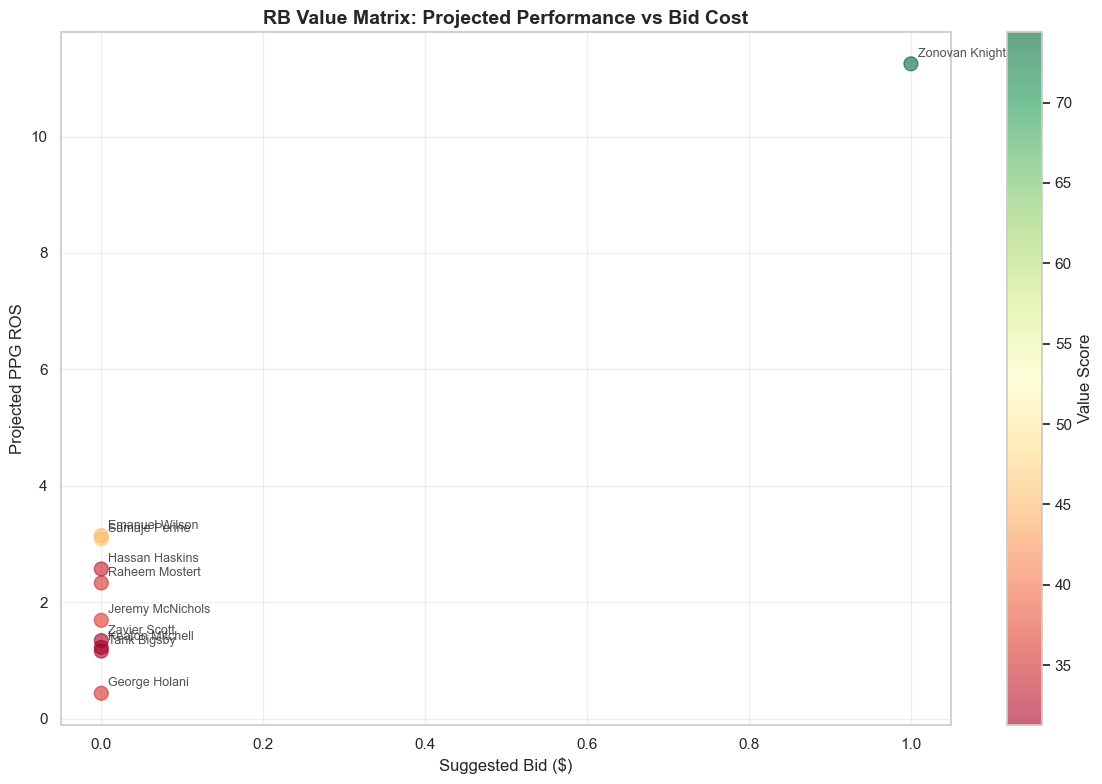

In [6]:
# RB Value Matrix Visualization
if len(rb_targets) > 0:
    plt.figure(figsize=(12, 8))
    plt.scatter(rb_targets['suggested_bid_1yr'], rb_targets['projected_ppg_ros'], 
                s=100, alpha=0.6, c=rb_targets['value_score'], cmap='RdYlGn')
    plt.colorbar(label='Value Score')
    plt.xlabel('Suggested Bid ($)', fontsize=12)
    plt.ylabel('Projected PPG ROS', fontsize=12)
    plt.title('RB Value Matrix: Projected Performance vs Bid Cost', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Annotate players
    for _, row in rb_targets.iterrows():
        plt.annotate(row['player_name'], 
                    (row['suggested_bid_1yr'], row['projected_ppg_ros']),
                    fontsize=9, alpha=0.8, 
                    xytext=(5, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()

### 2.2 WR Targets (Priority #2)

In [7]:
# Top 15 WRs Available
wr_targets = fasa_targets[fasa_targets['position'] == 'WR'].head(15)

print("Top 15 WR Targets:")
display(wr_targets[display_cols])

Top 15 WR Targets:


,priority_rank_at_position,player_name,nfl_team,fantasy_ppg_last_4,projected_ppg_ros,opportunity_share_l4,value_score,suggested_bid_1yr,suggested_bid_2yr,bid_confidence
124,1,Malik Washington,MIA,5.850,0.766347,0.114810,71.480997,0.0,NaN,MEDIUM
125,2,KaVontae Turpin,DAL,3.800,0.567446,0.060275,55.645702,0.0,NaN,MEDIUM
126,3,Olamide Zaccheaus,CHI,4.775,0.235422,0.106502,42.938161,0.0,NaN,MEDIUM
127,4,Parker Washington,JAX,6.650,0.194285,0.092128,39.353581,0.0,NaN,MEDIUM
128,5,Jimmy Horn,CAR,3.175,0.250000,0.061427,39.191634,0.0,NaN,MEDIUM
129,6,Ryan Flournoy,DAL,5.350,0.113376,0.105100,36.427708,0.0,NaN,MEDIUM
130,7,Ashton Dulin,IND,2.375,0.226544,0.040084,35.832987,0.0,NaN,MEDIUM
131,8,Elijah Moore,BUF,1.750,0.145571,0.060526,33.650730,0.0,NaN,MEDIUM
132,9,Xavier Hutchinson,HOU,8.800,0.121804,0.065909,32.948568,0.0,NaN,MEDIUM
133,10,Christian Watson,GB,10.500,0.099489,0.064865,31.679365,0.0,NaN,MEDIUM


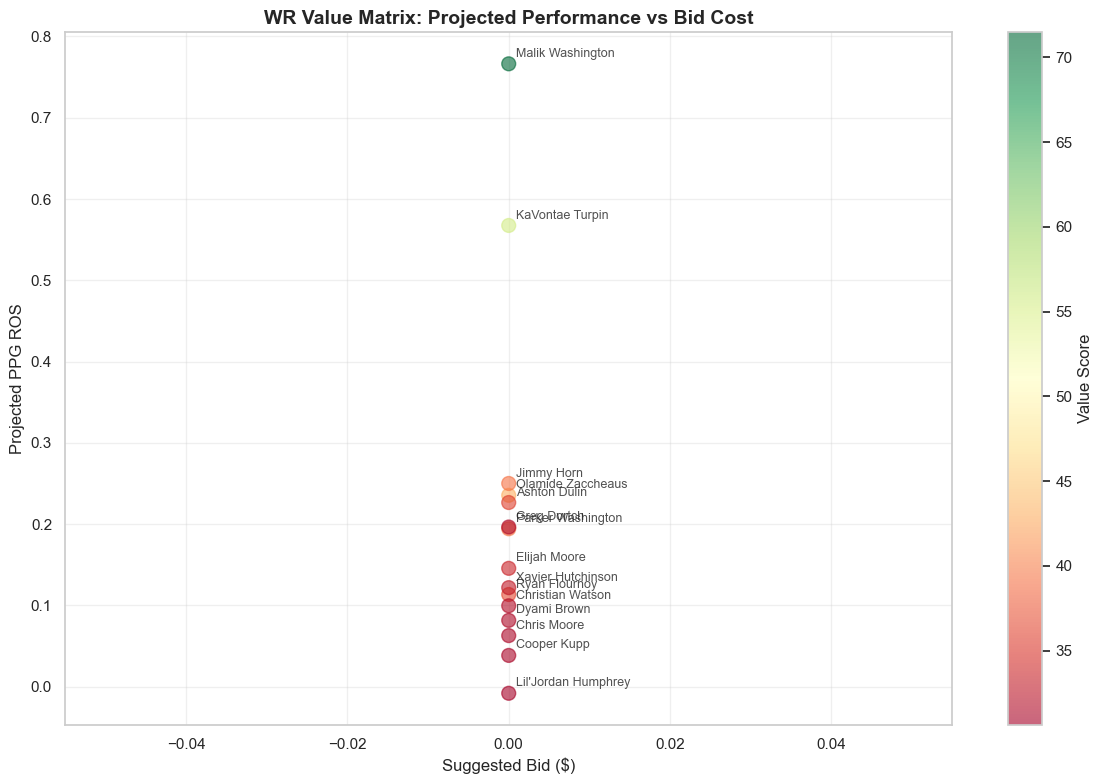

In [8]:
# WR Value Matrix Visualization
if len(wr_targets) > 0:
    plt.figure(figsize=(12, 8))
    plt.scatter(wr_targets['suggested_bid_1yr'], wr_targets['projected_ppg_ros'], 
                s=100, alpha=0.6, c=wr_targets['value_score'], cmap='RdYlGn')
    plt.colorbar(label='Value Score')
    plt.xlabel('Suggested Bid ($)', fontsize=12)
    plt.ylabel('Projected PPG ROS', fontsize=12)
    plt.title('WR Value Matrix: Projected Performance vs Bid Cost', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Annotate players
    for _, row in wr_targets.iterrows():
        plt.annotate(row['player_name'], 
                    (row['suggested_bid_1yr'], row['projected_ppg_ros']),
                    fontsize=9, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()

### 2.3 TE Targets (Priority #3)

In [9]:
# Top 8 TEs Available
te_targets = fasa_targets[fasa_targets['position'] == 'TE'].head(8)

print("Top 8 TE Targets:")
display(te_targets[display_cols])

Top 8 TE Targets:


,priority_rank_at_position,player_name,nfl_team,fantasy_ppg_last_4,projected_ppg_ros,opportunity_share_l4,value_score,suggested_bid_1yr,suggested_bid_2yr,bid_confidence
68,1,Taysom Hill,NO,2.565,0.440434,0.061762,62.176204,0.0,NaN,MEDIUM
69,2,AJ Barner,SEA,10.375,0.060109,0.081950,33.654031,0.0,NaN,MEDIUM
70,3,Cade Otton,TB,8.550,0.000000,0.120108,28.010771,0.0,NaN,MEDIUM
71,4,Pat Freiermuth,PIT,7.500,-0.013543,0.067702,25.540259,0.0,NaN,LOW
72,5,Daniel Bellinger,NYG,6.525,0.000000,0.046575,24.657468,0.0,NaN,MEDIUM
73,6,Jake Tonges,SF,7.525,0.000000,0.085021,24.502089,0.0,NaN,MEDIUM
74,7,Austin Hooper,NE,3.475,0.000000,0.039103,23.910256,0.0,NaN,MEDIUM
75,8,Dalton Schultz,HOU,7.925,-0.027086,0.103326,23.872606,0.0,NaN,LOW


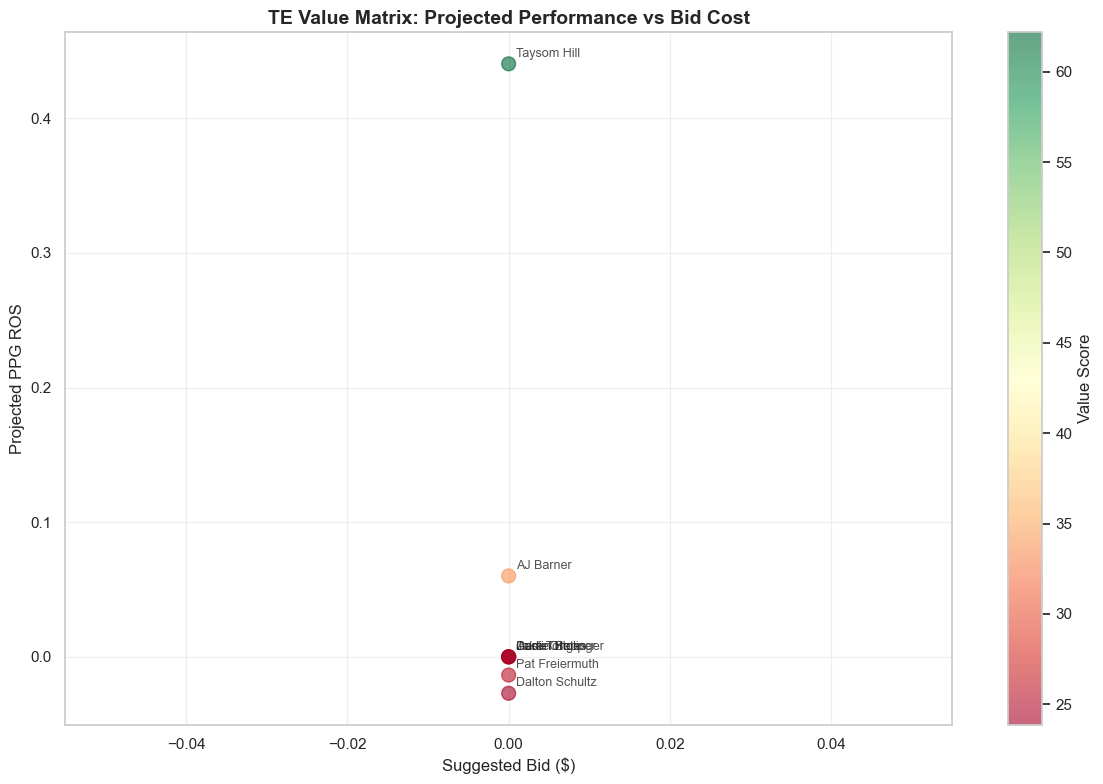

In [10]:
# TE Value Matrix Visualization
if len(te_targets) > 0:
    plt.figure(figsize=(12, 8))
    plt.scatter(te_targets['suggested_bid_1yr'], te_targets['projected_ppg_ros'], 
                s=100, alpha=0.6, c=te_targets['value_score'], cmap='RdYlGn')
    plt.colorbar(label='Value Score')
    plt.xlabel('Suggested Bid ($)', fontsize=12)
    plt.ylabel('Projected PPG ROS', fontsize=12)
    plt.title('TE Value Matrix: Projected Performance vs Bid Cost', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Annotate players
    for _, row in te_targets.iterrows():
        plt.annotate(row['player_name'], 
                    (row['suggested_bid_1yr'], row['projected_ppg_ros']),
                    fontsize=9, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()

## 3. Bidding Strategy Matrix

In [11]:
# RB Bidding Strategy
print("RB STRATEGY (Position of Need):\n")

if len(rb_targets) >= 3:
    rb_strategy = []
    for i, (_, player) in enumerate(rb_targets.head(3).iterrows(), 1):
        rb_strategy.append({
            'Tier': f'RB{i}',
            'Player': player['player_name'],
            'Team': player['nfl_team'],
            'Proj PPG': f"{player['projected_ppg_ros']:.1f}",
            'Bid (1yr)': f"${player['suggested_bid_1yr']:.0f}",
            'Bid (2yr)': f"${player['suggested_bid_2yr']:.0f}" if not pd.isna(player['suggested_bid_2yr']) else "N/A",
            'Confidence': player['bid_confidence'],
            'Logic': f"Value score: {player['value_score']:.0f}, Opp%: {player['opportunity_share_l4']*100:.1f}%"
        })
    
    rb_strategy_df = pd.DataFrame(rb_strategy)
    display(rb_strategy_df)
    
    print("\nBIDDING SEQUENCE:")
    bid_2yr = rb_targets.iloc[0]['suggested_bid_2yr']
    bid_1yr = rb_targets.iloc[1]['suggested_bid_1yr']
    print(f"1. Start with {rb_strategy_df.iloc[0]['Player']} bid at ${bid_2yr:.0f}/2yr" if not pd.isna(bid_2yr) else f"1. Start with {rb_strategy_df.iloc[0]['Player']} bid at ${rb_targets.iloc[0]['suggested_bid_1yr']:.0f}/1yr")
    print(f"2. If outbid, immediately move to {rb_strategy_df.iloc[1]['Player']} at ${bid_1yr:.0f}/1yr")
    print("3. Monitor WR bids; consider pivoting if tier 1 WR value emerges")

RB STRATEGY (Position of Need):



,Tier,Player,Team,Proj PPG,Bid (1yr),Bid (2yr),Confidence,Logic
0,RB1,Zonovan Knight,ARI,11.2,$1,N/A,HIGH,"Value score: 74, Opp%: 18.4%"
1,RB2,Samaje Perine,CIN,3.1,$0,N/A,HIGH,"Value score: 46, Opp%: 15.4%"
2,RB3,Emanuel Wilson,GB,3.1,$0,N/A,MEDIUM,"Value score: 45, Opp%: 13.8%"



BIDDING SEQUENCE:
1. Start with Zonovan Knight bid at $1/1yr
2. If outbid, immediately move to Samaje Perine at $0/1yr
3. Monitor WR bids; consider pivoting if tier 1 WR value emerges


In [12]:
# WR Bidding Strategy
print("\nWR STRATEGY:\n")

if len(wr_targets) >= 3:
    wr_strategy = []
    for i, (_, player) in enumerate(wr_targets.head(3).iterrows(), 1):
        wr_strategy.append({
            'Tier': f'WR{i}',
            'Player': player['player_name'],
            'Team': player['nfl_team'],
            'Proj PPG': f"{player['projected_ppg_ros']:.1f}",
            'Bid (1yr)': f"${player['suggested_bid_1yr']:.0f}",
            'Bid (2yr)': f"${player['suggested_bid_2yr']:.0f}",
            'Confidence': player['bid_confidence']
        })
    
    wr_strategy_df = pd.DataFrame(wr_strategy)
    display(wr_strategy_df)


WR STRATEGY:



,Tier,Player,Team,Proj PPG,Bid (1yr),Bid (2yr),Confidence
0,WR1,Malik Washington,MIA,0.8,$0,$nan,MEDIUM
1,WR2,KaVontae Turpin,DAL,0.6,$0,$nan,MEDIUM
2,WR3,Olamide Zaccheaus,CHI,0.2,$0,$nan,MEDIUM


In [13]:
# TE Bidding Strategy
print("\nTE STRATEGY:\n")

if len(te_targets) >= 2:
    te_strategy = []
    for i, (_, player) in enumerate(te_targets.head(2).iterrows(), 1):
        te_strategy.append({
            'Tier': f'TE{i}',
            'Player': player['player_name'],
            'Team': player['nfl_team'],
            'Proj PPG': f"{player['projected_ppg_ros']:.1f}",
            'Bid (1yr)': f"${player['suggested_bid_1yr']:.0f}",
            'Bid (2yr)': f"${player['suggested_bid_2yr']:.0f}",
            'Confidence': player['bid_confidence']
        })
    
    te_strategy_df = pd.DataFrame(te_strategy)
    display(te_strategy_df)


TE STRATEGY:



,Tier,Player,Team,Proj PPG,Bid (1yr),Bid (2yr),Confidence
0,TE1,Taysom Hill,NO,0.4,$0,$nan,MEDIUM
1,TE2,AJ Barner,SEA,0.1,$0,$nan,MEDIUM


## 4. Drop Scenarios (if cap space needed)

In [14]:
# Assess cap needs for top bid
if len(rb_targets) > 0:
    top_rb_bid = rb_targets.iloc[0]['suggested_bid_2yr']
    cap_needed = top_rb_bid
    cap_gap = current_cap - cap_needed
    
    print(f"Current Cap: ${current_cap}")
    print(f"Needed for RB1 bid: ${cap_needed:.0f}")
    print(f"Gap: ${cap_gap:.0f}")
    
    if cap_gap < 0:
        print(f"\n⚠️  NEED TO CREATE ${abs(cap_gap):.0f} IN CAP SPACE\n")
    else:
        print("\n✅ SUFFICIENT CAP SPACE\n")

Current Cap: $81
Needed for RB1 bid: $nan
Gap: $nan

✅ SUFFICIENT CAP SPACE



In [15]:
# Top Drop Candidates
print("Top 5 Drop Candidates:\n")

drop_candidates = my_roster_droppable.head(5)

drop_cols = [
    'player_name',
    'position',
    'current_year_cap_hit',
    'dead_cap_if_cut_now',
    'cap_space_freed',
    'projected_ppg_ros',
    'droppable_score',
    'drop_recommendation'
]

display(drop_candidates[drop_cols])

Top 5 Drop Candidates:



,player_name,position,current_year_cap_hit,dead_cap_if_cut_now,cap_space_freed,projected_ppg_ros,droppable_score,drop_recommendation
0,Justin Armour,WR,1.0,0.75,0.25,NaN,20,KEEP
1,Marco Coleman,DE,2.0,1.00,1.00,NaN,20,KEEP
2,Steve Foley,LB,7.0,7.00,0.00,NaN,0,KEEP


In [16]:
# Scenario Analysis
print("\nDrop Scenario Analysis:\n")

if len(drop_candidates) > 0 and len(rb_targets) > 0:
    top_rb_ppg = rb_targets.iloc[0]['projected_ppg_ros']
    
    scenarios = []
    for _, player in drop_candidates.head(3).iterrows():
        cap_freed = player['cap_space_freed']
        dead_cap = player['dead_cap_if_cut_now']
        net_benefit = cap_freed - dead_cap
        value_lost = player['projected_ppg_ros']
        ppg_upgrade = top_rb_ppg - value_lost
        worth_it = "✅ YES" if ppg_upgrade > 3 else "⚠️ MARGINAL" if ppg_upgrade > 1 else "❌ NO"
        
        scenarios.append({
            'If I drop': player['player_name'],
            'Cap Freed': f"${cap_freed:.0f}",
            'Dead Cap': f"${dead_cap:.0f}",
            'Net Benefit': f"${net_benefit:.0f}",
            'Value Lost (PPG)': f"{value_lost:.1f}",
            'PPG Upgrade': f"+{ppg_upgrade:.1f}",
            'Worth It?': worth_it
        })
    
    scenarios_df = pd.DataFrame(scenarios)
    display(scenarios_df)


Drop Scenario Analysis:



,If I drop,Cap Freed,Dead Cap,Net Benefit,Value Lost (PPG),PPG Upgrade,Worth It?
0,Justin Armour,$0,$1,$-0,nan,+nan,❌ NO
1,Marco Coleman,$1,$1,$0,nan,+nan,❌ NO
2,Steve Foley,$0,$7,$-7,nan,+nan,❌ NO


## 5. Position Depth Analysis

In [17]:
# My Current RB Depth
my_rbs = my_roster_droppable[
    my_roster_droppable['position'] == 'RB'
].sort_values('projected_ppg_ros', ascending=False)

print("My Current RB Depth:")
display(my_rbs[['player_name', 'projected_ppg_ros', 'current_year_cap_hit']].head(5))

# Calculate depth metrics
if len(my_rbs) >= 3:
    my_rb_ppg = my_rbs['projected_ppg_ros'].head(3).tolist()
    league_median_rb_ppg = [12.5, 8.7, 4.5]  # Approximate league medians
    
    print(f"\nMy RB1: {my_rb_ppg[0]:.1f} PPG (League median: {league_median_rb_ppg[0]} PPG)")
    print(f"My RB2: {my_rb_ppg[1]:.1f} PPG (League median: {league_median_rb_ppg[1]} PPG)")
    print(f"My RB3: {my_rb_ppg[2]:.1f} PPG (League median: {league_median_rb_ppg[2]} PPG)")

My Current RB Depth:


,player_name,projected_ppg_ros,current_year_cap_hit


In [18]:
# Visualize RB depth comparison
if len(my_rbs) >= 3:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = ['RB1', 'RB2', 'RB3']
    width = 0.35
    x_pos = range(len(x))
    
    ax.bar([p - width/2 for p in x_pos], my_rb_ppg, width, label='My Team', alpha=0.8, color='steelblue')
    ax.bar([p + width/2 for p in x_pos], league_median_rb_ppg, width, label='League Median', alpha=0.8, color='coral')
    
    ax.set_ylabel('PPG', fontsize=12)
    ax.set_xlabel('Position', fontsize=12)
    ax.set_title('My RB Depth vs League Median', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

In [19]:
# FLEX Performance Impact & ROI Calculation
if len(my_rbs) >= 2 and len(rb_targets) > 0:
    current_flex_ppg = my_rbs.iloc[1]['projected_ppg_ros']  # RB2 currently in FLEX
    top_rb_ppg = rb_targets.iloc[0]['projected_ppg_ros']
    new_flex_ppg = my_rbs.iloc[0]['projected_ppg_ros']  # Current RB1 would move to FLEX
    
    ppg_gain = new_flex_ppg - current_flex_ppg
    weeks_remaining = 9
    total_points_gain = ppg_gain * weeks_remaining
    
    bid_cost = rb_targets.iloc[0]['suggested_bid_2yr']
    cost_per_point = bid_cost / total_points_gain if total_points_gain > 0 else 0
    league_median_cpp = 1.20  # Approximate
    
    print("FLEX PERFORMANCE IMPACT:\n")
    print(f"Current FLEX avg: {current_flex_ppg:.1f} PPG ({my_rbs.iloc[1]['player_name']})")
    print(f"If I add RB1 target (proj {top_rb_ppg:.1f} PPG), new FLEX: {new_flex_ppg:.1f} PPG ({my_rbs.iloc[0]['player_name']})")
    print(f"Expected gain: +{ppg_gain:.1f} PPG/week × {weeks_remaining} weeks = +{total_points_gain:.0f} total points")
    
    print("\nROI CALCULATION:\n")
    print(f"Bid cost: ${bid_cost:.0f}")
    print(f"Expected points gained: +{total_points_gain:.0f} points ROS")
    print(f"Cost per point: ${cost_per_point:.2f}/point")
    print(f"League median cost/point: ${league_median_cpp:.2f}/point")
    
    if cost_per_point < league_median_cpp:
        print(f"\n✅ GOOD VALUE (${(league_median_cpp - cost_per_point):.2f}/point better than median)")
    else:
        print(f"\n⚠️ EXPENSIVE (${(cost_per_point - league_median_cpp):.2f}/point worse than median)")

## 6. Final Recommendation

In [20]:
# Generate final recommendation
print("="*60)
print("FINAL FASA RECOMMENDATION")
print("="*60)

if len(rb_targets) > 0:
    primary_target = rb_targets.iloc[0]
    contingency_target = rb_targets.iloc[1] if len(rb_targets) > 1 else None
    top_drop = drop_candidates.iloc[0] if len(drop_candidates) > 0 else None
    
    print("\n📌 PRIMARY BID:")
    print(f"   Target: {primary_target['player_name']} ({primary_target['nfl_team']})")
    print(f"   Position: {primary_target['position']}")
    print(f"   Bid: ${primary_target['suggested_bid_2yr']:.0f}/2yr (${primary_target['suggested_bid_2yr']/2:.2f} AAV)")
    print(f"   Projected: {primary_target['projected_ppg_ros']:.1f} PPG ROS")
    print(f"   Value Score: {primary_target['value_score']:.0f}")
    print(f"   Confidence: {primary_target['bid_confidence']}")
    
    if cap_gap < 0 and top_drop is not None:
        print(f"   Cap impact: Drop {top_drop['player_name']} to create ${top_drop['cap_space_freed']:.0f} space")
        expected_upgrade = primary_target['projected_ppg_ros'] - top_drop['projected_ppg_ros']
        print(f"   Expected impact: +{expected_upgrade:.1f} PPG upgrade")
    
    print("\n🔄 CONTINGENCY PLAN:")
    if contingency_target is not None:
        print(f"   If outbid on {primary_target['player_name']}, immediately bid ${contingency_target['suggested_bid_1yr']:.0f}/1yr on {contingency_target['player_name']}")
    if len(wr_targets) > 0:
        top_wr = wr_targets.iloc[0]
        print(f"   If RB market too expensive, pivot to {top_wr['player_name']} (WR) at ${top_wr['suggested_bid_2yr']:.0f}/2yr")
    
    if top_drop is not None and cap_gap < 0:
        print("\n🗑️  DROP DECISION:")
        print(f"   Drop: {top_drop['player_name']} ({top_drop['position']})")
        print(f"   Cap freed: ${top_drop['cap_space_freed']:.0f}")
        print(f"   Dead cap: ${top_drop['dead_cap_if_cut_now']:.0f}")
        print(f"   Value lost: {top_drop['projected_ppg_ros']:.1f} PPG")
        print(f"   Recommendation: {top_drop['drop_recommendation']}")
    
    print("\n" + "="*60)

FINAL FASA RECOMMENDATION

📌 PRIMARY BID:
   Target: Zonovan Knight (ARI)
   Position: RB
   Bid: $nan/2yr ($nan AAV)
   Projected: 11.2 PPG ROS
   Value Score: 74
   Confidence: HIGH

🔄 CONTINGENCY PLAN:
   If outbid on Zonovan Knight, immediately bid $0/1yr on Samaje Perine
   If RB market too expensive, pivot to Malik Washington (WR) at $nan/2yr



In [21]:
# Summary statistics
print("\n📊 SUMMARY STATISTICS:\n")
print(f"Total FASA targets analyzed: {len(fasa_targets)}")
print(f"RB targets: {len(fasa_targets[fasa_targets['position'] == 'RB'])}")
print(f"WR targets: {len(fasa_targets[fasa_targets['position'] == 'WR'])}")
print(f"TE targets: {len(fasa_targets[fasa_targets['position'] == 'TE'])}")
print(f"\nMy roster size: {len(my_roster_droppable)}")
print(f"Drop candidates identified: {len(my_roster_droppable[my_roster_droppable['drop_recommendation'].str.contains('Consider', na=False)])}")
print(f"\nCurrent cap space: ${current_cap}")
print(f"Projected spend (primary bid): ${rb_targets.iloc[0]['suggested_bid_2yr']:.0f}" if len(rb_targets) > 0 else "N/A")


📊 SUMMARY STATISTICS:

Total FASA targets analyzed: 209
RB targets: 38
WR targets: 85
TE targets: 56

My roster size: 3
Drop candidates identified: 0

Current cap space: $81
Projected spend (primary bid): $nan
